In [1]:
#載入套件
import pandas as pd
pd.set_option("display.max_rows", None, "display.max_columns", None)
import numpy as np
np.set_printoptions(precision=3, suppress=True)
import seaborn as sns
sns.set(style='whitegrid')
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import regularizers
from keras import preprocessing
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, precision_recall_curve, auc
from sklearn.feature_selection import f_classif
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.stats import chi2_contingency
import math
import uuid
import random
import zipfile
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

ModuleNotFoundError: No module named 'tensorflow'

In [1]:
#載入套件
import pandas as pd
pd.set_option("display.max_rows", None, "display.max_columns", None)
import numpy as np
np.set_printoptions(precision=3, suppress=True)
import seaborn as sns
sns.set(style='whitegrid')
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import regularizers
from keras import preprocessing
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, precision_recall_curve, auc
from sklearn.feature_selection import f_classif
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.stats import chi2_contingency
import math
import uuid
import random
import zipfile
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

ModuleNotFoundError: No module named 'tensorflow'

In [2]:
nvidia-smi

NameError: name 'nvidia' is not defined

In [3]:
pip install tensorflow==2.12.*

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 585.9/585.9 MB 1.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 30.1 MB/s eta 0:00:00:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.4/302.4 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 46.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.9/22.9 MB 46.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 52.5 MB/s eta 0:00:00:00:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 66.3 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.5/126.5 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━

In [1]:
#載入套件
import pandas as pd
pd.set_option("display.max_rows", None, "display.max_columns", None)
import numpy as np
np.set_printoptions(precision=3, suppress=True)
import seaborn as sns
sns.set(style='whitegrid')
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import regularizers
from keras import preprocessing
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, precision_recall_curve, auc
from sklearn.feature_selection import f_classif
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.stats import chi2_contingency
import math
import uuid
import random
import zipfile
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

2023-04-07 03:13:37.254709: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-07 03:13:39.724058: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-07 03:13:39.744543: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-07 03:13:42.861448: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
#載入套件
import pandas as pd
pd.set_option("display.max_rows", None, "display.max_columns", None)
import numpy as np
np.set_printoptions(precision=3, suppress=True)
import seaborn as sns
sns.set(style='whitegrid')
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import regularizers
from keras import preprocessing
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, precision_recall_curve, auc
from sklearn.feature_selection import f_classif
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.stats import chi2_contingency
import math
import uuid
import random
import zipfile
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

In [3]:
# 分割x and y
def split_x_y(data_train,data_test,target="kredit"):

  train_y = data_train[target]
  train_x = data_train.drop(target, axis=1)

  test_x = data_test.drop(target, axis=1)
  test_y = data_test[target]

  return train_x, train_y, test_x, test_y

# 
def add_id(original_df):
  id = pd.Series(range(0,1000)).apply(lambda i : str(uuid.uuid4()))
  df_with_id = original_df.copy()
  df_with_id['id'] = id
  df_with_id = df_with_id.set_index('id')

  return df_with_id

def split_columns(df_with_id,columns_list,target):
  colum_1 = columns_list.copy()
  colum_1.append(target)
  colum_2 = columns_list.copy()
  # 分割欄位
  client1_data = df_with_id[colum_1]
  client2_data = df_with_id.drop(colum_2, axis=1)

  # 切割資料
  client1_train, client1_test = train_test_split(client1_data, test_size=0.2, random_state=0)
  client2_train, client2_test = train_test_split(client2_data, test_size=0.2, random_state=0)


  # 切割x,y
  client1_train_x,client1_train_y, client1_test_x, client1_test_y = split_x_y(client1_train,client1_test,target)
  client2_train_x,client2_train_y, client2_test_x, client2_test_y = split_x_y(client2_train,client2_test,target)

  # 找出共同的index
  common_train_index = client1_train.index.intersection(client2_train.index)
  common_test_index = client1_test.index.intersection(client2_test.index)

  return client1_train_x,client1_train_y, client1_test_x, client1_test_y, client2_train_x,client2_train_y, client2_test_x, client2_test_y, common_train_index, common_test_index

In [4]:
# model
# normalize data
def normalize_data(data):
  normalizer = tf.keras.layers.Normalization()
  normalizer.adapt(np.array(data))
  return normalizer

In [5]:
#client
class Client:

  def __init__(self, train_data_x,train_data_y, test_data_x,test_data_y, labelled,model):
    self.__trainX = train_data_x.copy()
    self.__testX = test_data_x.copy()
    self.labelled = labelled
    self.__trainY = train_data_y.copy()
    self.__testY = test_data_y.copy()
    self.model = model
    
  def next_batch(self, index):
    self.batchX = self.__trainX.loc[index]

    if not self.labelled:
      grads = []
      self.model_output = np.zeros((len(index), 2))
      for i in range(len(index)):
        with tf.GradientTape() as gt:
          gt.watch(self.model.trainable_weights)
          output_by_example = self.model(self.batchX.iloc[i:i+1], training=True)
          output_for_grad = output_by_example[:,1]
        self.model_output[i] = output_by_example
        grads.append(gt.gradient(output_for_grad, self.model.trainable_weights))

      return grads
    
    else:
      self.batchY = self.__trainY.loc[index]
      with tf.GradientTape() as self.gt:
        self.gt.watch(self.model.trainable_weights)
        self.model_output = self.model(self.batchX, training=True)
  def cal_model(self):
    return self.model_output
  
  def predict(self, test_index):
    return self.model.predict(self.__testX.loc[test_index])# + 1e-8

  def predict_all(self, index):
    return self.model.predict(pd.concat([self.__trainX, self.__testX]).loc[index])

  def test_answers(self, test_index):
    if self.labelled:
      return self.__testY.loc[test_index]
    
  def test_answers_all(self, index):
    if self.labelled:
      return pd.concat([self.__testY, self.__trainY]).loc[index]
  
  def batch_answers(self):
    if self.labelled:
      return self.batchY

  def loss_and_update(self, a):
    if not self.labelled:
      raise AssertionError("This method can only be called by client 2")
    self.prob = (a + self.model_output)/2
    self.c = self.coefficient_and_update()/len(self.batchX)
    return self.prob, loss_fn(self.batchY, self.prob)
  
  def coefficient_and_update(self):
    if not self.labelled:
      raise AssertionError("This method can only be called by client 2")
    p = self.prob[:,1]
    c = (p-self.batchY)/((p)*(1-p))
    with self.gt:
      output = sum(c * self.model_output[:,1])/len(c)
    grads = self.gt.gradient(output, self.model.trainable_weights)
    optimizer.apply_gradients(zip(grads, self.model.trainable_weights))
    return c
  
  def update_with(self, grads):
    optimizer.apply_gradients(zip(grads, self.model.trainable_weights))

  def assemble_grad(self, partial_grads):
    if not self.labelled:
      raise AssertionError("This method can only be called by client 2")
    # to assemble the gradient for client 1
    for i in range(len(self.c)):
      partial_grads[i] = [x * self.c[i] for x in partial_grads[i]]
    return [sum(x) for x in zip(*partial_grads)]
# 畫圖
# roc curve
def draw_roc_curve(fpr, tpr,auc):
  fig, ax = plt.subplots()
  plt.title('Receiver Operating Characteristic')
  plt.plot(fpr, tpr, color = 'orange', label = 'AUC = %0.2f' % auc)
  plt.legend(loc = 'lower right')
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()  


# 訓練圖
def plot_loss(loss, accuracy):
  fig, ax = plt.subplots()
  plt.plot(loss, label='loss')
  plt.plot(accuracy, label='accuracy')
  plt.xlabel('Epoch')
  # plt.ylabel('Error')
  plt.legend()
  plt.grid(True)

# 準確率圖
def plot_accuracy(predictions, answers, threshold):
  tp, tn, fp, fn = 0, 0, 0, 0

  for x in range(len(predictions)):
    if answers[x] == 1:
      # if np.argmax(predictions[x]) == 1:
      if predictions[x][1] >= threshold:
        tp = tp + 1
      else:
        fn = fn + 1
    else:
      # if np.argmax(predictions[x]) == 0:
      if predictions[x][1] < threshold:
        tn = tn + 1
      else:
        fp = fp + 1
  
  accuracy = (tp + tn)/(tp + fp + fn + tn)
  precision = tp / (tp + fp)
  recall = tp / (tp + fn)
  specificity = tn / (tn + fp)
  print("Accuracy: " + str(accuracy))
  print("Precision: " + str(precision))
  print("Recall: " + str(recall))
  # print("Specificity: " + str(specificity))
  print("F-Measure: " + str(2*(recall * precision) / (recall + precision)))

In [6]:
# 下載資料
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00573/SouthGermanCredit.zip
with zipfile.ZipFile('SouthGermanCredit.zip', 'r') as zip_ref:
    zip_ref.extractall('./SouthGermanCredit/')

--2023-04-07 03:13:54--  https://archive.ics.uci.edu/ml/machine-learning-databases/00573/SouthGermanCredit.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13130 (13K) [application/x-httpd-php]
Saving to: ‘SouthGermanCredit.zip’

SouthGermanCredit.z 100%[===================>]  12.82K  --.-KB/s    in 0s      

2023-04-07 03:13:55 (85.8 MB/s) - ‘SouthGermanCredit.zip’ saved [13130/13130]



In [7]:
# 清理資料
original_df = pd.read_csv('./SouthGermanCredit/SouthGermanCredit.asc', sep=' ')
original_df.describe()
original_df=original_df.dropna()


# Normalize all columns
scaler = MinMaxScaler()
df_norm = scaler.fit_transform(original_df)
original_df =pd.DataFrame(df_norm,columns=original_df.columns)

# choose target
target='kredit'
columns_list = ['rate',	'famges',	'buerge',	'wohnzeit',	'verm',	'alter',	'weitkred',	'wohn',	'bishkred',	'beruf'	,'pers'	,'telef',	'gastarb']
# 添加id
df_with_id = add_id(original_df)
# 切割資料
client1_train_x,client1_train_y, client1_test_x, client1_test_y, client2_train_x,client2_train_y, client2_test_x, client2_test_y, common_train_index, common_test_index = split_columns(df_with_id,columns_list=columns_list,target=target)
# 顯示訓練測試資料大小
print(
    'There are {} common entries (out of {}) in client 1 and client 2\'s training datasets,\nand {} common entries (out of {}) in their test datasets'
    .format(
        len(common_train_index),
        len(client1_train_x),
        len(common_test_index),
        len(client1_test_x)))

There are 800 common entries (out of 800) in client 1 and client 2's training datasets,
and 200 common entries (out of 200) in their test datasets


In [8]:
#vfl
# 設定參數
batch_size = 32
learning_rate = 1e-3
epochs = 50

# Instantiate an optimizer.
optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate)
# Instantiate a loss function.
# Not from logits because of the softmax layer converting logits to probability.
loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=False)
# Instantiate a metric function (accuracy)
train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

In [9]:
# init client
normalizer1 = normalize_data(client1_train_x.loc[common_train_index])
model1 =   tf.keras.Sequential([
      normalizer1,
      layers.Dense(128, activation='elu', kernel_regularizer=regularizers.l2(0.01)),
      layers.Dropout(0.5),
      layers.Dense(128, activation='elu', kernel_regularizer=regularizers.l2(0.01)),
      layers.Dropout(0.5),
      layers.Dense(2),
      layers.Softmax()])
client1 = Client(client1_train_x, client1_train_y,client1_test_x,client1_test_y, False,model1)


normalizer2 = normalize_data(client2_train_x.loc[common_train_index])
model2 = tf.keras.Sequential([
      normalizer2,
      layers.Dense(128, activation='elu', kernel_regularizer=regularizers.l2(0.01)),
      layers.Dropout(0.5),
      layers.Dense(128, activation='elu', kernel_regularizer=regularizers.l2(0.01)),
      layers.Dropout(0.5),
      layers.Dense(2),
      layers.Softmax()])
client2 = Client(client2_train_x, client2_train_y,client2_test_x,client2_test_y, True,model2)

run in 0 epoch
-----train accuracy0.6462500095367432-----
run in 1 epoch
-----train accuracy0.7462499737739563-----
run in 2 epoch
-----train accuracy0.7462499737739563-----
run in 3 epoch
-----train accuracy0.7599999904632568-----
run in 4 epoch
-----train accuracy0.7325000166893005-----
run in 5 epoch
-----train accuracy0.7549999952316284-----
run in 6 epoch
-----train accuracy0.7549999952316284-----
run in 7 epoch
-----train accuracy0.7562500238418579-----
run in 8 epoch
-----train accuracy0.7524999976158142-----
run in 9 epoch
-----train accuracy0.7524999976158142-----
run in 10 epoch
-----train accuracy0.762499988079071-----
run in 11 epoch
-----train accuracy0.7574999928474426-----
run in 12 epoch
-----train accuracy0.7387499809265137-----
run in 13 epoch
-----train accuracy0.7450000047683716-----
run in 14 epoch
-----train accuracy0.75-----
run in 15 epoch
-----train accuracy0.7599999904632568-----
run in 16 epoch
-----train accuracy0.7437499761581421-----
run in 17 epoch
-----t

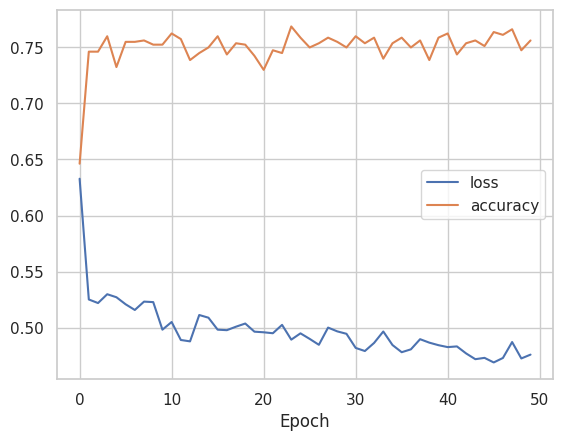

In [10]:
# train_on_client
common_train_index_list = common_train_index.to_list()
epoch_loss = []
epoch_acc = []

for epoch in range(epochs):
    print(f'run in {epoch} epoch')
    # epoch=0
    random.shuffle(common_train_index_list)
    train_index_batches = [common_train_index_list[i:i + batch_size] for i in range(0, len(common_train_index_list), batch_size)] 
    total_loss = 0.0
    # Iterate over the batches of the dataset.
    for step, batch_index in enumerate(train_index_batches):
        
        partial_grads = client1.next_batch(batch_index)
        client2.next_batch(batch_index)

        prob, loss_value = client2.loss_and_update(client1.cal_model())
        grad = client2.assemble_grad(partial_grads)
        client1.update_with(grad)
        
        total_loss = loss_value + total_loss
        train_acc_metric.update_state(client2.batch_answers(), prob)
    train_acc = train_acc_metric.result()
    print(f'-----train accuracy{train_acc}-----')
    train_acc_metric.reset_states()
    epoch_loss.append((total_loss)/(step + 1))
    epoch_acc.append(train_acc)

plot_loss(epoch_loss, epoch_acc)

7/7 [==============================] - 0s 2ms/step


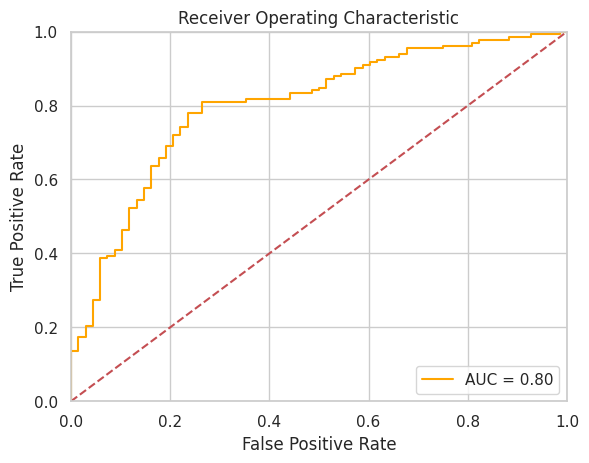

AUC: 0.8008021390374331
Best Threshold=0.648541, G-Mean=0.772

Accuracy: 0.775
Precision: 0.865546218487395
Recall: 0.7803030303030303
F-Measure: 0.8207171314741035


In [11]:
# 預測結果
vfl_pred_test = (client1.predict(common_test_index) + client2.predict(common_test_index))/2

# 計算roc,auc
vfl_fpr_test, vfl_tpr_test, vfl_thresholds_test = roc_curve(client2.test_answers(common_test_index), vfl_pred_test[:,1])
auc1 = auc(vfl_fpr_test, vfl_tpr_test)
draw_roc_curve(vfl_fpr_test, vfl_tpr_test,auc1)
print("AUC: {}".format(auc1 ))

# 計算threshold 值
vfl_gmeans_test = np.sqrt(vfl_tpr_test * (1-vfl_fpr_test))
vfl_ix_test = np.argmax(vfl_gmeans_test)
best_threshold = vfl_thresholds_test[vfl_ix_test]
print('Best Threshold=%f, G-Mean=%.3f\n' % (vfl_thresholds_test[vfl_ix_test], vfl_gmeans_test[vfl_ix_test]))

# 準確率
plot_accuracy(vfl_pred_test, client2.test_answers(common_test_index), best_threshold)

# save result
df=pd.DataFrame(client2.test_answers(common_test_index))
vfl_pred_test_label = [1 if p >= best_threshold else 0 for p in  vfl_pred_test[:,1]]
df['predict']=vfl_pred_test_label
df.to_csv('vfl_cen_predict.csv',encoding ='UTF-8-sig')
#evalueate

In [12]:
# ----------------------------------centralized----------------------------

In [13]:
# 設定參數
batch_size = 32
learning_rate = 1e-3
epochs = 20

# Instantiate a metric function (accuracy)
train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

Epoch 1: Loss=2.1795, Accuracy=0.5675
Epoch 2: Loss=1.8996, Accuracy=0.6600
Epoch 3: Loss=1.7224, Accuracy=0.6575
Epoch 4: Loss=1.5652, Accuracy=0.6612
Epoch 5: Loss=1.4456, Accuracy=0.6737
Epoch 6: Loss=1.3186, Accuracy=0.6975
Epoch 7: Loss=1.2412, Accuracy=0.6900
Epoch 8: Loss=1.1676, Accuracy=0.7013
Epoch 9: Loss=1.1130, Accuracy=0.6900
Epoch 10: Loss=1.0619, Accuracy=0.6963
Epoch 11: Loss=1.0210, Accuracy=0.6888
Epoch 12: Loss=0.9611, Accuracy=0.7013
Epoch 13: Loss=0.9210, Accuracy=0.7025
Epoch 14: Loss=0.8935, Accuracy=0.7000
Epoch 15: Loss=0.8633, Accuracy=0.7125
Epoch 16: Loss=0.8356, Accuracy=0.7000
Epoch 17: Loss=0.8167, Accuracy=0.7025
Epoch 18: Loss=0.7854, Accuracy=0.7038
Epoch 19: Loss=0.7646, Accuracy=0.7125
Epoch 20: Loss=0.7473, Accuracy=0.7088
7/7 - 0s - loss: 0.7889 - accuracy: 0.6900 - 148ms/epoch - 21ms/step

Test accuracy: 0.6899999976158142
7/7 [==============================] - 0s 1ms/step


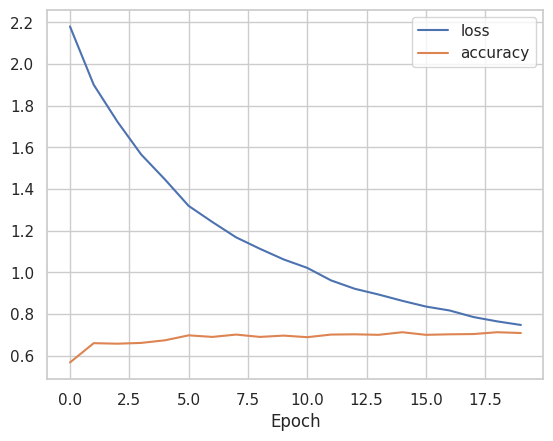

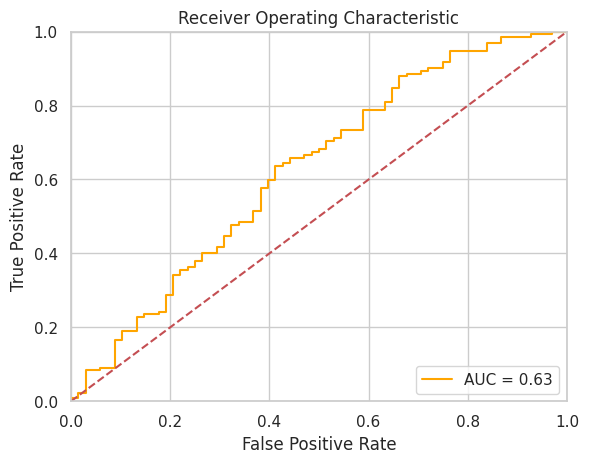

AUC: 0.8008021390374331
Best Threshold=0.700888, G-Mean=0.612

Accuracy: 0.62
Precision: 0.75
Recall: 0.6363636363636364
F-Measure: 0.6885245901639345


In [14]:
# init cen_1
normalizer_cen1 = normalize_data(client1_train_x.loc[common_train_index])
model_cen1 = model_cen1 = tf.keras.Sequential([
      normalizer_cen1,
      layers.Dense(128, activation='elu', kernel_regularizer=regularizers.l2(0.01)),
      layers.Dropout(0.5),
      layers.Dense(128, activation='elu', kernel_regularizer=regularizers.l2(0.01)),
      layers.Dropout(0.5),
      layers.Dense(2),
      layers.Softmax()])


epoch_loss=[]
epoch_acc=[]
# custom callback
class PrintMetricsCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        epoch_loss.append(logs["loss"])
        epoch_acc.append(logs["accuracy"])
        print(f'Epoch {epoch+1}: Loss={logs["loss"]:.4f}, Accuracy={logs["accuracy"]:.4f}')


model_cen1.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])


# fit1
test_results = {}
cen1_history = model_cen1.fit(client1_train_x, client1_train_y, epochs=epochs, verbose=0, batch_size=batch_size, callbacks=[PrintMetricsCallback()])


#evaluate
test_loss, test_acc = model_cen1.evaluate(client1_test_x, client1_test_y, verbose=2)
print('\nTest accuracy:', test_acc)


# result
cen1_pred_test= model_cen1.predict(client1_test_x)

# plot loss
plot_loss(epoch_loss, epoch_acc)
# 計算roc,auc
cen1_fpr_test, cen1_tpr_test, cen1_thresholds_test = roc_curve(client1_test_y, cen1_pred_test[:,1])
auc_cen1 = auc(cen1_fpr_test, cen1_tpr_test)
draw_roc_curve(cen1_fpr_test, cen1_tpr_test,auc=auc_cen1)
print("AUC: {}".format(auc1 ))

# 計算threshold 值

cen1_gmeans_test = np.sqrt(cen1_tpr_test * (1-cen1_fpr_test))
cen1_ix_test = np.argmax(cen1_gmeans_test)
best_threshold_cen1 = cen1_thresholds_test[cen1_ix_test]
print('Best Threshold=%f, G-Mean=%.3f\n' % (cen1_thresholds_test[cen1_ix_test], cen1_gmeans_test[cen1_ix_test]))


# probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])

plot_accuracy(cen1_pred_test,client1_test_y,best_threshold_cen1)
cen1_pred_test_label = [1 if p >= best_threshold_cen1 else 0 for p in  cen1_pred_test[:,1]]
df['predict_cen1']=cen1_pred_test_label
df.to_csv('vfl_cen_predict.csv',encoding ='UTF-8-sig')

Epoch 1: Loss=1.9353, Accuracy=0.6550
Epoch 2: Loss=1.6424, Accuracy=0.6850
Epoch 3: Loss=1.4384, Accuracy=0.7175
Epoch 4: Loss=1.2784, Accuracy=0.7437
Epoch 5: Loss=1.1654, Accuracy=0.7275
Epoch 6: Loss=1.0623, Accuracy=0.7513
Epoch 7: Loss=0.9879, Accuracy=0.7312
Epoch 8: Loss=0.9163, Accuracy=0.7237
Epoch 9: Loss=0.8510, Accuracy=0.7513
Epoch 10: Loss=0.8182, Accuracy=0.7425
Epoch 11: Loss=0.7776, Accuracy=0.7400
Epoch 12: Loss=0.7449, Accuracy=0.7575
Epoch 13: Loss=0.7090, Accuracy=0.7538
Epoch 14: Loss=0.7006, Accuracy=0.7475
Epoch 15: Loss=0.6718, Accuracy=0.7525
Epoch 16: Loss=0.6553, Accuracy=0.7450
Epoch 17: Loss=0.6412, Accuracy=0.7387
Epoch 18: Loss=0.6380, Accuracy=0.7350
Epoch 19: Loss=0.6154, Accuracy=0.7600
Epoch 20: Loss=0.6045, Accuracy=0.7613
7/7 - 0s - loss: 0.5904 - accuracy: 0.7450 - 155ms/epoch - 22ms/step

Test accuracy: 0.7450000047683716
7/7 [==============================] - 0s 1ms/step


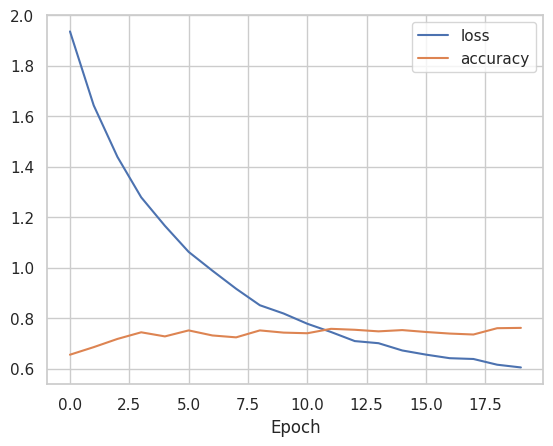

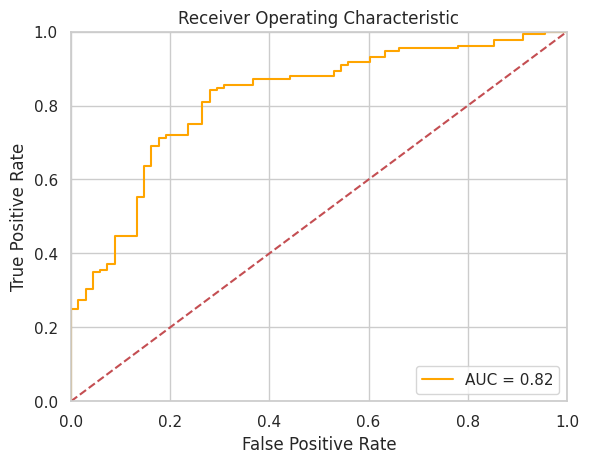

AUC: 0.8189616755793226
Best Threshold=0.653802, G-Mean=1.203

Accuracy: 0.8
Precision: 0.8432835820895522
Recall: 0.8560606060606061
F-Measure: 0.849624060150376


In [15]:
# init cen_2
normalizer_cen2 = normalize_data(client2_train_x.loc[common_train_index])
model_cen2 = tf.keras.Sequential([
      normalizer_cen2,
      layers.Dense(128, activation='elu', kernel_regularizer=regularizers.l2(0.01)),
      layers.Dropout(0.5),
      layers.Dense(128, activation='elu', kernel_regularizer=regularizers.l2(0.01)),
      layers.Dropout(0.5),
      layers.Dense(2),
      layers.Softmax()])

epoch_loss=[]
epoch_acc=[]
# custom callback
class PrintMetricsCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        epoch_loss.append(logs["loss"])
        epoch_acc.append(logs["accuracy"])
        print(f'Epoch {epoch+1}: Loss={logs["loss"]:.4f}, Accuracy={logs["accuracy"]:.4f}')


model_cen2.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])


# fit2
test_results = {}
cen2_history = model_cen2.fit(client2_train_x, client2_train_y, epochs=epochs, verbose=0, batch_size=batch_size, callbacks=[PrintMetricsCallback()])


#evaluate
test_loss, test_acc = model_cen2.evaluate(client2_test_x, client2_test_y, verbose=2)
print('\nTest accuracy:', test_acc)


# result
cen2_pred_test= model_cen2.predict(client2_test_x)

# plot loss
plot_loss(epoch_loss, epoch_acc)

# 計算roc,auc
cen2_fpr_test, cen2_tpr_test, cen2_thresholds_test = roc_curve(client2_test_y, cen2_pred_test[:,1])
auc_cen2 = auc(cen2_fpr_test, cen2_tpr_test)
draw_roc_curve=draw_roc_curve(cen2_fpr_test, cen2_tpr_test,auc=auc_cen2)
print("AUC: {}".format(auc_cen2 ))

# 計算threshold 值

cen2_gmeans_test = np.sqrt(cen2_tpr_test * (2-cen2_fpr_test))
cen2_ix_test = np.argmax(cen2_gmeans_test)
best_threshold_cen2 = cen2_thresholds_test[cen2_ix_test]
print('Best Threshold=%f, G-Mean=%.3f\n' % (cen2_thresholds_test[cen2_ix_test], cen2_gmeans_test[cen2_ix_test]))

# save result
# probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])
plot_accuracy(cen2_pred_test,client2_test_y,best_threshold_cen2)
cen2_pred_test_label = [1 if p >= best_threshold_cen2 else 0 for p in  cen2_pred_test[:,1]]
df['predict_cen2']=cen2_pred_test_label
df.to_csv('vfl_cen_predict.csv',encoding ='UTF-8-sig')